### Import packages and load functions

In [2]:
# Importing modules to access and visualise data
import xarray as xr # used for netcdf and h5 files, climate data
import h5py
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfea
from pyproj import Transformer
import pyproj
import datetime
from scipy.interpolate import griddata
from scipy.stats import binned_statistic_2d
import os, sys
from matplotlib.colors import LinearSegmentedColormap

In [3]:
def WGS84toEASE2N(lon, lat):
    proj_EASE2N = pyproj.Proj("+proj=laea +lon_0=0 +lat_0=90 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")
    proj_WGS84 = pyproj.Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs ")
    x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)

    return x, y


def LOAD_MISR_H5(MISR_path):
    file_path = MISR_path
    file = h5py.File(file_path, 'r')
    roughness = file['Roughness']['Roughness_2D_svm']
    data = np.array(roughness)
    file.close()
    
    return data


def MISR_COORDS(MISR_path):
    file_path = MISR_path
    file = h5py.File(file_path, 'r')
    lon_MISR = np.array(file['GeoLocation']['Longitude'])
    lat_MISR = np.array(file['GeoLocation']['Latitude'])
    x_MISR = np.array(file['GeoLocation']['x'])
    y_MISR = np.array(file['GeoLocation']['y'])
    file.close()
    
    return lon_MISR, lat_MISR, x_MISR, y_MISR



def LOAD_MPF(MPF_path): 
    # Loads data from Sangyun Lee dataset on CPOM servers, just for month of JULY
    file_path = MPF_path
    ds = xr.open_dataset(file_path)
    data = np.array(ds['july_monthly'])
    
    return data

    

def MPF_UCL_COORDS(MPF_UCL_cords_path): 
    # reads coordinate data from sangyun lee mpf data set
    file_path = MPF_UCL_cords_path
    ds = xr.open_dataset(file_path)
    lon_MPF = ds['mp_lon']
    lat_MPF = ds['mp_lat']
        
    return np.asarray(lon_MPF), np.asarray(lat_MPF)


def interpolate_to_MISR(X_grid_in,Y_grid_in,Z_in,X_grid_out,Y_grid_out): 
    # function interpolates z data in which has shape X_in, Y_in to the same shape as X_out, Y_out
    z = griddata((X_grid_in.ravel(),Y_grid_in.ravel()),Z_in.ravel(),(X_grid_out.ravel(),Y_grid_out.ravel()),'nearest').reshape(8000,8000) 
    # to actually interpolate to MISR, need MISR x, y grid in and to reshape to 8000x8000 but can work with other shapes
    return z


# custom function to pass to statistic 
def nanmean(x):
    return np.nanmean(x)


def calculate_binned_averages(mpf, roughness, lat):

    roughness = roughness.ravel()
    lat = lat.ravel()

    # Define the number of bins for latitude and roughness
    num_lat_bins = 30
    num_rough_bins = 20

    # Calculate the 2D binning and get the average values of mpf in each bin
    averages, _, _, _ = binned_statistic_2d(
        lat,
        roughness,
        mpf,
        statistic = nanmean,
        bins=[num_lat_bins, num_rough_bins],
        range=[[60, 90], [0, 0.5]]
    )

    return averages


def plot_binned_stats(averages, title):

    y_tick_positions = np.linspace(0, 30, 7) # Takes default tick markings and changes them to the range of the data
    x_tick_positions = np.linspace(0, 20, 5)
    y_tick_labels = np.linspace(60, 90, 7) # Genate latitude values for 60 to 90
    x_tick_labels = np.linspace(0, 0.5, 5)


    plt.xticks(x_tick_positions, x_tick_labels) # Relabel ticks
    plt.yticks(y_tick_positions, y_tick_labels)

    plt.ylabel("Latitude")
    plt.xlabel("Roughness")

    plt.pcolor(averages)
    plt.colorbar()
    plt.title(title)

    # Show the plot
    plt.show()


def plot_binned_accuracy(accuracy, colour_map):

    y_tick_positions = np.linspace(0, 30, 7) # Takes default tick markings and changes them to the range of the data
    x_tick_positions = np.linspace(0, 20, 5)
    y_tick_labels = np.linspace(60, 90, 7) # Genate latitude values for 60 to 90
    x_tick_labels = np.linspace(0, 0.5, 5)


    plt.xticks(x_tick_positions, x_tick_labels) # Relabel ticks
    plt.yticks(y_tick_positions, y_tick_labels)

    plt.ylabel("Latitude")
    plt.xlabel("Roughness")

    plt.pcolor(accuracy, cmap = colour_map)
    plt.colorbar()

    # Show the plot
    plt.show()


def MASK_MPF_MISR(mpf_MISRGRID, MISR):
    # Create masks for valid data in each array
    mask1 = ~np.isnan(mpf_MISRGRID)  # Invert the NaN values to get a mask of valid data
    mask2 = ~np.isnan(MISR)

    # Create a joint mask where both arrays have valid data
    joint_mask = mask1 & mask2

    # Use the joint mask to apply the mask to both arrays and corresponding latitude
    masked_MPF_MISRGRID = np.ma.masked_array(mpf_MISRGRID, mask=~joint_mask)
    masked_MISR = np.ma.masked_array(MISR, mask=~joint_mask)
    masked_lat_MISR = np.ma.masked_array(lat_MISR, mask=~joint_mask)

    return masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR


def format_date(year, month, day):
    return f"{year}-{month}-{day} 12:00:00"


In [32]:
YEAR = 2019

# load advected MPF data
mpf_advected = pd.read_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/mpf_from_{YEAR}0401_183 days_spacing_8.pkl')
print(f'MPF retrieved. Shape: {mpf_advected.shape}')
lat_advected = pd.read_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/lat_from_{YEAR}0401_183 days_spacing_8.pkl')
print(f'Latitudes retrieved. Shape: {lat_advected.shape}')
lon_advected = pd.read_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/lon_from_{YEAR}0401_183 days_spacing_8.pkl')
print(f'Longitudes retrieved. Shape: {lon_advected.shape}')


MPF retrieved. Shape: (184, 1000000)
Latitudes retrieved. Shape: (184, 1000000)
Longitudes retrieved. Shape: (184, 1000000)


In [33]:
# subset full mpf dataframe to retrieve just the days to average
date_from = format_date(YEAR, '05', '01')
date_to = format_date(YEAR, '08', '31')
subset_mpf = mpf_advected.loc[date_from:date_to]

# find mean of subsetted advected mpfs
mean_mpf_advected = np.nanmean(subset_mpf, axis=0).reshape(1000,1000)
np.shape(mean_mpf_advected)


/tmp/ipykernel_140964/1207071983.py:7: RuntimeWarning: Mean of empty slice
  mean_mpf_advected = np.nanmean(subset_mpf, axis=0).reshape(1000,1000)


(1000, 1000)

In [34]:
# load original observed meltpond fraction
may_mpf = np.load('/home/htweedie/melt_ponds/data/OLCI/olci/2017/mean_05_2017.npy').ravel()
jun_mpf = np.load('/home/htweedie/melt_ponds/data/OLCI/olci/2017/mean_06_2017.npy').ravel()
jul_mpf = np.load('/home/htweedie/melt_ponds/data/OLCI/olci/2017/mean_07_2017.npy').ravel()
aug_mpf = np.load('/home/htweedie/melt_ponds/data/OLCI/olci/2017/mean_08_2017.npy').ravel()

# calculate mean
mpf_observed = np.array([may_mpf, jun_mpf, jul_mpf, aug_mpf])
mean_mpf_observed = np.nanmean(mpf_observed, axis=0)
np.shape(mean_mpf_observed)


/tmp/ipykernel_140964/2947751639.py:9: RuntimeWarning: Mean of empty slice
  mean_mpf_observed = np.nanmean(mpf_observed, axis=0)


(544768,)

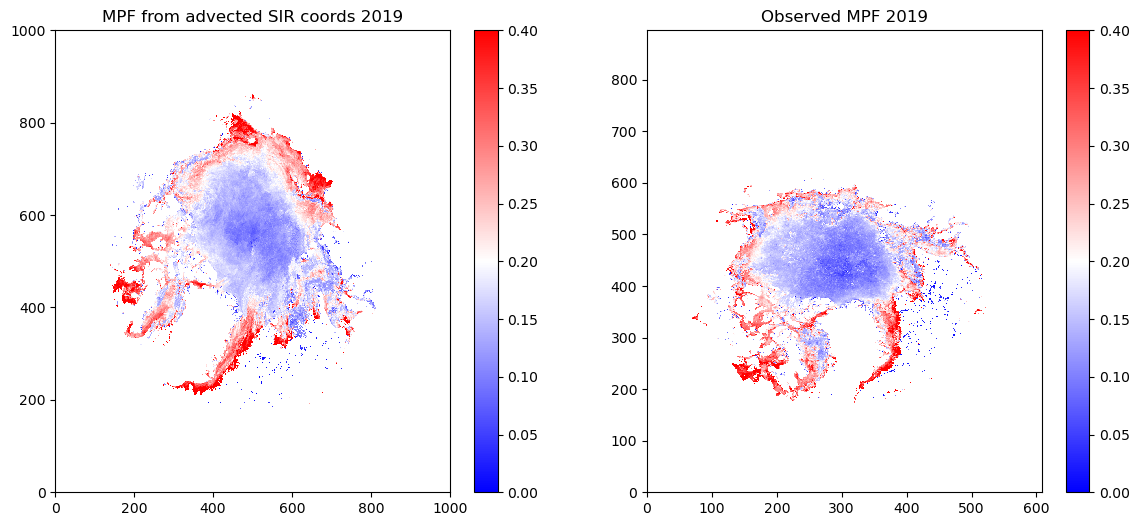

In [38]:
fig = plt.figure(figsize=(14,6))
plt.set_cmap('bwr')

plt.subplot(121)
plt.pcolormesh(mean_mpf_advected, vmin=0, vmax=0.4)
plt.title(f'MPF from advected SIR coords {YEAR}')
plt.colorbar()

plt.subplot(122)
plt.pcolormesh(mean_mpf_observed.reshape(896, 608), vmin=0, vmax=0.4)
plt.title(f'Observed MPF {YEAR}')
plt.colorbar()